In [141]:
import json
import numpy as np
import pandas as pd
from inline_sql import sql 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Importación tablas

In [300]:
produccion = pd.read_csv("prod-no-nula.csv")
pozos = pd.read_csv("pozos-con-geo-info.csv")

C:\Users\carri\AppData\Local\Temp\ipykernel_22336\3190033060.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  produccion = pd.read_csv("prod-no-nula.csv")


# F)

In [417]:
def pozo_outliers (df, id_pozo, plot):
    # Producciones de 2024 del pozo
    meses = df[df['idpozo'] == id_pozo][['idpozo', 'mes', 'prod_pet', 'prod_gas']]
    # Cuartiles Petroleo
    Q1 = np.percentile(meses['prod_pet'], 25)
    Q3 = np.percentile(meses['prod_pet'], 75)
    # Bigotes Petroleo
    bigote_sup = Q3 + 1.5*(Q3-Q1)
    bigote_inf = Q1 - 1.5*(Q3-Q1)
    # Anómalo Petroleo
    meses['anomalo_pet'] =  (meses['prod_pet'] < bigote_inf) | (meses['prod_pet'] > bigote_sup)

    if (plot):
        def formatter(x, pos):
            return f'{x:,.0f}'
            
        colores = ['red', 'yellow', 'green']
        condiciones = [(meses['prod_pet'] < bigote_inf) | (meses['prod_pet'] > bigote_sup),
                       (meses['prod_pet'] >= bigote_inf) & (meses['prod_pet'] <= bigote_sup) & ((meses['prod_pet'] < Q1) | (meses['prod_pet'] > Q3)),
                       (meses['prod_pet'] >= Q1) & (meses['prod_pet'] <= Q3)]
        colores = ['red', 'orange', 'green']
        meses['color'] = np.select(condiciones, colores, default='gray')
        
        fig, ax = plt.subplots(figsize=(7,4))

        ax.plot(meses['mes'], meses['prod_pet'], color='gray')
        ax.set_ylim(ymin=max(0,ax.get_ylim()[0]) , ymax=ax.get_ylim()[1])
        
        ax.axhline(y=bigote_sup, linestyle='--', color='red')
        ax.axhspan(bigote_sup, ax.get_ylim()[1], color='red', alpha=0.1)
        
        ax.axhline(y=bigote_inf, linestyle='--', color='red')
        ax.axhspan(ax.get_ylim()[0], bigote_inf, color='red', alpha=0.1)
        
        ax.axhline(y=Q1, linestyle='--', color='orange')
        ax.axhspan(bigote_inf, Q1, color='orange', alpha=0.1)
        
        ax.axhline(y=Q3, linestyle='--', color='orange')
        ax.axhspan(Q3, bigote_sup, color='orange', alpha=0.1)

        ax.axhspan(Q1, Q3, color='green', alpha=0.1)
        ax.grid(axis='x', linewidth=0.5, linestyle='--')

        ax.scatter(meses['mes'], meses['prod_pet'], c=meses['color'], alpha=1, s=50)
        ax.set(xticks=meses['mes'])
        ax.set_xlabel('Mes')
        ax.set_ylabel('Producción de petróleo (m3)')
    
    # Cuartiles Gas
    Q1 = np.percentile(meses['prod_gas'], 25)
    Q3 = np.percentile(meses['prod_gas'], 75)
    # Bigotes Gas
    bigote_sup = Q3 + 1.5*(Q3-Q1)
    bigote_inf = Q1 - 1.5*(Q3-Q1)
    # Anómalo Gas
    meses['anomalo_gas'] =  (meses['prod_gas'] < bigote_inf) | (meses['prod_gas'] > bigote_sup)
    
    if (plot):
        def formatter(x, pos):
            return f'{x:,.0f}'
            
        colores = ['red', 'yellow', 'green']
        condiciones = [(meses['prod_gas'] < bigote_inf) | (meses['prod_gas'] > bigote_sup),
                       (meses['prod_gas'] >= bigote_inf) & (meses['prod_gas'] <= bigote_sup) & ((meses['prod_gas'] < Q1) | (meses['prod_gas'] > Q3)),
                       (meses['prod_gas'] >= Q1) & (meses['prod_gas'] <= Q3)]
        colores = ['red', 'orange', 'green']
        meses['color'] = np.select(condiciones, colores, default='gray')
        
        fig, ax = plt.subplots(figsize=(7,4))
        
        ax.plot(meses['mes'], meses['prod_gas'], color='gray')
        ax.set_ylim(ymin=max(0,ax.get_ylim()[0]), ymax=ax.get_ylim()[1])
        
        ax.axhline(y=bigote_sup, linestyle='--', color='red')
        ax.axhspan(bigote_sup, ax.get_ylim()[1], color='red', alpha=0.1)
        
        ax.axhline(y=bigote_inf, linestyle='--', color='red')
        ax.axhspan(ax.get_ylim()[0], bigote_inf, color='red', alpha=0.1)
        
        ax.axhline(y=Q1, linestyle='--', color='orange')
        ax.axhspan(bigote_inf, Q1, color='orange', alpha=0.1)
        
        ax.axhline(y=Q3, linestyle='--', color='orange')
        ax.axhspan(Q3, bigote_sup, color='orange', alpha=0.1)

        ax.axhspan(Q1, Q3, color='green', alpha=0.1)
        ax.grid(axis='x', linewidth=0.5, linestyle='--')
        
        ax.scatter(meses['mes'], meses['prod_gas'], c=meses['color'], alpha=1, s=50)
        ax.set(xticks=meses['mes'])
        ax.set_xlabel('Mes')
        ax.set_ylabel('Producción de gas (miles de m3)')
        
    return meses[['mes', 'anomalo_pet', 'anomalo_gas']]
    

,mes,anomalo_pet,anomalo_gas
140977,1,True,False
141142,2,True,False
141255,3,False,False
141351,4,False,False
141388,5,False,False
141565,6,False,False
141636,7,False,False
141886,8,False,True
142014,9,False,False
142104,10,True,True


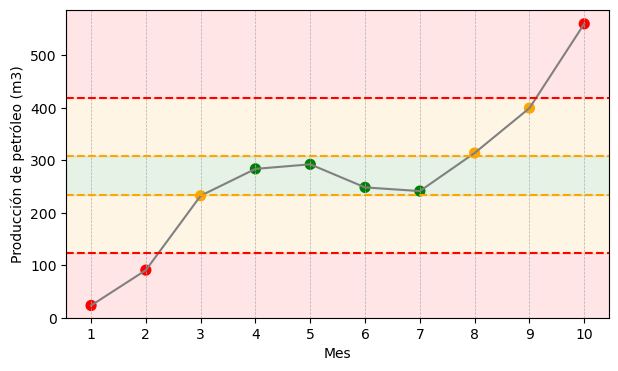

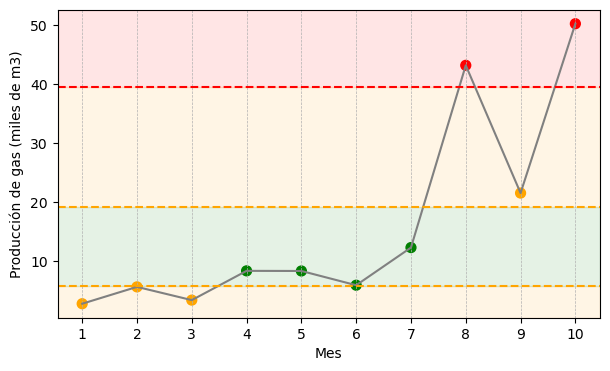

In [418]:
pozo_outliers(produccion, 147021, True)

In [341]:
def outliers (produccion, rango):
    outliers_pet = {}
    outliers_gas = {}
    ids = produccion['idpozo'].unique()
    for i in range (rango[0], rango[1]):
        idpozo = int(ids[i])
        # Outliers del pozo
        outliers = pozo_outliers(produccion, idpozo, False)
        # Outliers de petroleo
        if (outliers['anomalo_pet'].any()):
            meses_outliers = outliers[outliers['anomalo_pet'] == True] ['mes']
            outliers_pet[idpozo] = meses_outliers.to_list()
            
        # Outliers de gas   
        if (outliers['anomalo_gas'].any()):
            meses_outliers = outliers[outliers['anomalo_gas'] == True] ['mes']
            outliers_gas[idpozo] = meses_outliers.to_list()
        
    return outliers_pet, outliers_gas

In [333]:
len(produccion['idpozo'].unique())

27715

In [342]:
outliers_pet, outliers_gas = outliers(produccion,(0,27715))

In [343]:
len(outliers_pet)

9813

In [344]:
len(outliers_gas)

9260

,mes,anomalo_pet,anomalo_gas
1133,1,False,False
12910,2,True,False
36656,3,False,False
38399,4,False,False
61302,5,False,False
75873,6,True,False
89053,7,False,False
102071,8,True,False
112559,9,True,False
127078,10,False,False


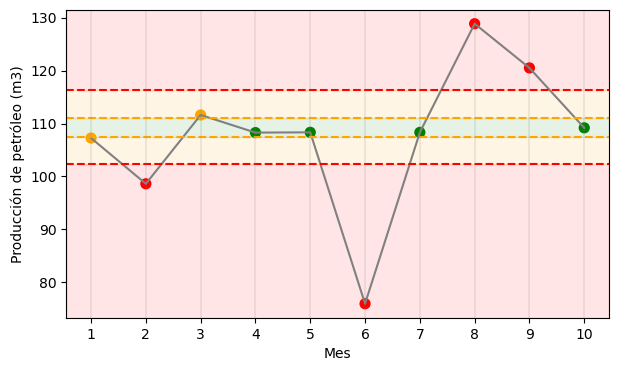

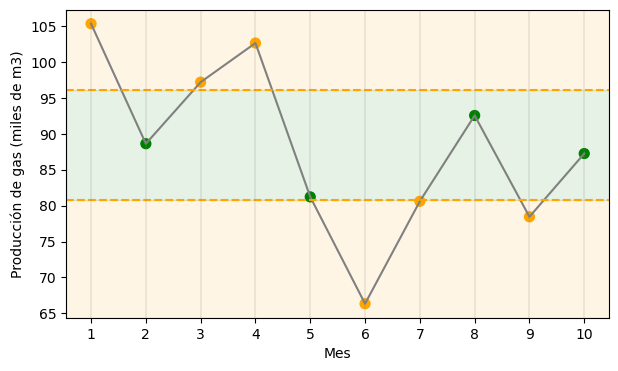

In [348]:
pozo_outliers(produccion, 145124, True)

# G)

In [371]:
producciones_provincias = pd.read_csv("produccin-de-petrleo-promedio-diaria-por-provincia.csv")
produccion23 = pd.read_csv("produccin-de-pozos-de-gas-y-petrleo-2023.csv")

C:\Users\carri\AppData\Local\Temp\ipykernel_22336\505827127.py:2: DtypeWarning: Columns (16,36) have mixed types. Specify dtype option on import or set low_memory=False.
  produccion23 = pd.read_csv("produccin-de-pozos-de-gas-y-petrleo-2023.csv")


In [459]:
def compare_2023 (df24, df23, id_pozo, plot):
    # Producciones de 2024 del pozo
    prods24 = df24[df24['idpozo'] == id_pozo][['mes', 'prod_pet', 'prod_gas']].reset_index()
    # Producciones de 2023 del pozo
    prods23 = df23[df23['idpozo'] == id_pozo][['mes', 'prod_pet', 'prod_gas']].reset_index()
    # Inicio columnas
    prods24['anomalo_pet'] = False
    prods24['anomalo_gas'] = False
    # Me quedo con los meses comunes
    prods23 = prods23[prods23['mes'].isin(prods24['mes'])]
    prods24 = prods24[prods24['mes'].isin(prods23['mes'])]
    
    if (prods24.shape[0] > 0):
        # Diferencias en produccion de petroleo entre años
        prods24['diferences_pet'] = abs(prods24['prod_pet'].values-prods23['prod_pet'].values)
        # Busco valores muy altos
        Q1 = np.percentile(prods24['diferences_pet'], 25)
        Q3 = np.percentile(prods24['diferences_pet'], 75)
        umbral = Q3 + 1.5*(Q3-Q1)
        # Filtro outliers
        prods24['anomalo_pet'] = (prods24['diferences_pet'] > umbral)
        # Ploteo
        if (plot):
            colores = ['red', 'orange', 'green']
            condiciones = [(prods24['diferences_pet'] > umbral),
                           (prods24['diferences_pet'] <= umbral) & (prods24['diferences_pet'] > Q3),
                           (prods24['diferences_pet'] < umbral)]
            prods24['color'] = np.select(condiciones, colores, default='gray')
            
            fig, ax = plt.subplots(figsize=(7,4))
            maxs = []
            mins = []
            for i in range (len(prods24['prod_pet'])):
                maxs.append(max(prods24['prod_pet'][i], prods23['prod_pet'][i]))
                mins.append(min(prods24['prod_pet'][i], prods23['prod_pet'][i]))
            
            ax.vlines(x=prods24['mes'], ymin=mins, ymax=maxs, colors=prods24['color'], linewidth=2)
            ax.scatter(prods24['mes'], prods24['prod_pet'], color='black', alpha=1, s=100, label='2024')
            ax.scatter(prods24['mes'], prods23['prod_pet'], color='black', alpha=0.5, s=100, label='2023')
    
            ax.grid(axis='y', linewidth=0.5, linestyle='--')
            ax.legend()
            ax.set(xticks=prods24['mes'])
            ax.set_xlabel('Mes')
            ax.set_ylabel('Producción de petróleo (m3)')
            
        # Diferencias en produccion de gas entre años
        prods24['diferences_gas'] = abs(prods24['prod_gas'].values-prods23['prod_gas'].values)
        # Busco valores muy altos
        Q1 = np.percentile(prods24['diferences_gas'], 25)
        Q3 = np.percentile(prods24['diferences_gas'], 75)
        umbral = Q3 + 1.5*(Q3-Q1)
        # Filtro outliers
        prods24['anomalo_gas'] = (prods24['diferences_gas'] > umbral)
        # Ploteo
        if (plot):
            colores = ['red', 'orange', 'green']
            condiciones = [(prods24['diferences_gas'] > umbral),
                           (prods24['diferences_gas'] <= umbral) & (prods24['diferences_gas'] > Q3),
                           (prods24['diferences_gas'] < umbral)]
            prods24['color'] = np.select(condiciones, colores, default='gray')
            
            fig, ax = plt.subplots(figsize=(7,4))
            maxs = []
            mins = []
            for i in range (len(prods24['prod_gas'])):
                maxs.append(max(prods24['prod_gas'][i], prods23['prod_gas'][i]))
                mins.append(min(prods24['prod_gas'][i], prods23['prod_gas'][i]))
            
            ax.vlines(x=prods24['mes'], ymin=mins, ymax=maxs, colors=prods24['color'], linewidth=2)
            ax.scatter(prods24['mes'], prods24['prod_gas'], color='black', alpha=1, s=100, label='2024')
            ax.scatter(prods24['mes'], prods23['prod_gas'], color='black', alpha=0.5, s=100, label='2023')
    
            ax.grid(axis='y', linewidth=0.5, linestyle='--')
            ax.legend()
            ax.set(xticks=prods24['mes'])
            ax.set_xlabel('Mes')
            ax.set_ylabel('Producción de gas (miles de m3)')

    return prods24[['mes', 'anomalo_pet', 'anomalo_gas']]

,mes,anomalo_pet,anomalo_gas
0,1,False,False
1,2,False,False
2,3,False,False
3,4,False,False
4,5,False,False
5,6,False,False
6,7,False,False
7,8,False,False
8,9,False,False
9,10,False,False


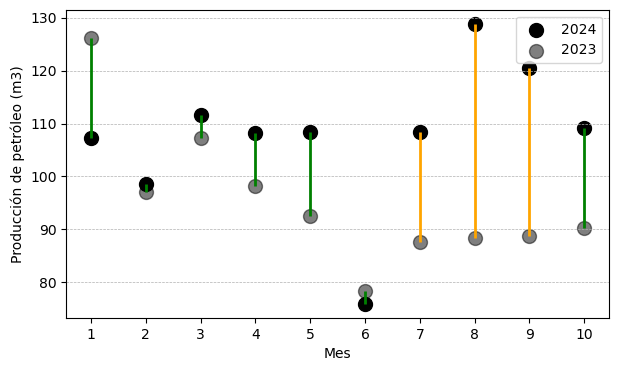

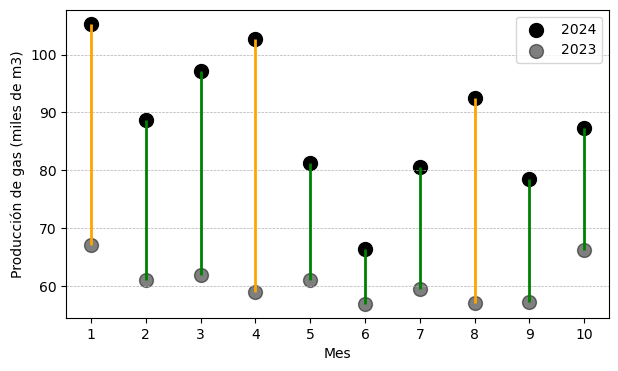

In [460]:
compare_2023(produccion, produccion23, 145124, True)

In [461]:
def outliers_comp23 (produccion, produccion23, rango):
    outliers_pet = {}
    outliers_gas = {}
    ids = produccion['idpozo'].unique()
    for i in range (rango[0], rango[1]):
        idpozo = int(ids[i])
        # Outliers del pozo
        outliers = compare_2023(produccion, produccion23, idpozo, False)
        # Checkeo dataframe no vacío
        if not (outliers.empty):
            # Outliers de petroleo
            if (outliers['anomalo_pet'].any()):
                meses_outliers = outliers[outliers['anomalo_pet'] == True] ['mes']
                outliers_pet[idpozo] = meses_outliers.to_list()
                
            # Outliers de gas   
            if (outliers['anomalo_gas'].any()):
                meses_outliers = outliers[outliers['anomalo_gas'] == True] ['mes']
                outliers_gas[idpozo] = meses_outliers.to_list()
        
    return outliers_pet, outliers_gas

In [462]:
outliers_comp23_pet, outliers_comp23_gas = outliers_comp23(produccion, produccion23, (0,27715))

In [463]:
len(outliers_comp23_pet)

6990

In [464]:
len(outliers_comp23_gas)

7138

,mes,anomalo_pet,anomalo_gas
0,1,False,False
1,2,False,False
2,3,False,True
3,4,False,False
4,5,False,False
5,6,False,False
6,7,False,False
7,8,False,True
8,9,False,False
9,10,False,False


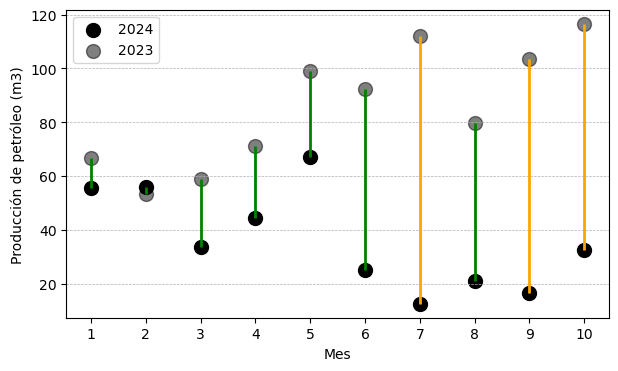

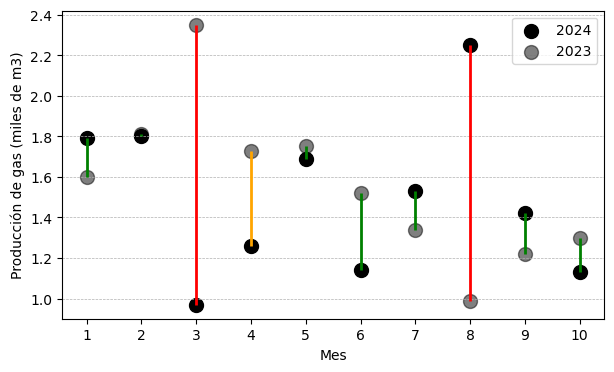

In [475]:
compare_2023(produccion, produccion23, 101876, True)